# TuRBO-ENN

This code implements TuRBO [1], a SOTA Bayesian optimization algorithm.

The optimization class, `Turbo`, supports four modes of operation.

**LHD_ONLY**  
Generate a Latin Hypercube Design (LHD) for every batch of arms. This is included as a simple baseline.

**TURBO_ZERO**  
Initialze with LHD. Afterward, sample near the best-so-far x value, x_best. Samples are "near" x_best in two senses: (i) They are in a trust region, an adaptively-sized box around x_best, and (ii) They perturb only a small number of dimensions using RAASP sampling [2]. Other dimensions take the same value as in x_best. The num_arms proposals are chosen randomly from RAASP candidates inside the trust region.

This is included to help differentiate the impact of the trust region from the impact of the surrogate. Notice (below) that the trust region has high impact.

**TURBO_ONE**  
This adds a GP surrogate to TURBO_ZERO. The num_arms proposals are chosen via Thompson sampling from RAASP candidates inside the trust region. Occasionally, the trust region adapter resets and (i) discards all observations, and (ii) begins anew with and LHD design.

This is the standard SOTA method. It should match the TuRBO reference [implementation](https://github.com/uber-research/TuRBO). 

**TURBO_ENN**  
This replaces the GP surrogate with a simpler, more scalable surrogate called Epistemic Nearest Neighbors (ENN). ENN's proposal time scales as $O(N)$ rather than the $O(N^2)$ of a GP surrogate. [3]


## References

1. **Eriksson, D., Pearce, M., Gardner, J. R., Turner, R., & Poloczek, M. (2020).** Scalable Global Optimization via Local Bayesian Optimization. *Advances in Neural Information Processing Systems, 32*.  
   https://arxiv.org/abs/1910.01739

2. **Rashidi, B., Johnstonbaugh, K., & Gao, C. (2024).** Cylindrical Thompson Sampling for High-Dimensional Bayesian Optimization. *Proceedings of The 27th International Conference on Artificial Intelligence and Statistics* (pp. 3502–3510). PMLR.  
   https://proceedings.mlr.press/v238/rashidi24a.html

3. **Sweet, D., & Jadhav, S. A. (2025).** Taking the GP Out of the Loop. *arXiv preprint arXiv:2506.12818*.  
   https://arxiv.org/abs/2506.12818


---

In [1]:
import numpy as np

from enn.benchmarks import Ackley

In [2]:
import time
import torch

from enn import create_optimizer
from enn.turbo.optimizer_config import (
    lhd_only_config,
    OptimizerConfig,
    turbo_enn_config,
    turbo_one_config,
    turbo_zero_config,
)


def run_optimization(config: OptimizerConfig, name: str):
    num_dim = 30
    num_iterations = 100
    num_arms = 10
    noise = 0.1
    use_y_hat = False

    rng = np.random.default_rng(18)
    torch.manual_seed(17)
    objective = Ackley(noise=noise, rng=rng)
    bounds = np.array([objective.bounds] * num_dim, dtype=float)

    optimizer = create_optimizer(
        bounds=bounds,
        config=config,
        rng=rng,
    )

    best_values = []
    proposal_times = []
    y_hat_best = -np.inf
    y_best = -np.inf

    for iteration in range(num_iterations):
        t_0 = time.time()
        x_arms = optimizer.ask(num_arms=num_arms)
        t_1 = time.time()
        proposal_times.append(t_1 - t_0)

        y_obs = objective(x_arms)

        y_hat = optimizer.tell(x_arms, y_obs, y_var=noise**2 * np.ones_like(y_obs))
        if use_y_hat:
            y_decide = y_hat
        else:
            y_decide = y_obs
        i = np.where(y_decide == np.max(y_decide))[0][0]
        y_hat_batch_best = y_decide[i]

        if y_hat_batch_best > y_hat_best:
            y_hat_best = y_hat_batch_best
            y_best = objective(x_arms[i])[0]

        best_values.append(y_best)
        if iteration % 10 == 0:
            print(
                f"{name} iteration = {iteration} y_best = {y_best} y_hat_best = {y_hat_best}"
            )

    evals = num_arms * np.arange(len(best_values))
    return best_values, proposal_times, evals

In [3]:
import os

import matplotlib.pyplot as plt

from enn.turbo.optimizer_config import (
    AcqType,
    CandidateGenConfig,
    CandidateRV,
    ENNFitConfig,
    ENNSurrogateConfig,
    TurboTRConfig,
)


RUN_TURBO_ONE = False

RUN_TURBO_ONE &= os.environ.get("FAST_TEST", "0") != "1"

best_values_zero, proposal_times_zero, evals_zero = run_optimization(
    turbo_zero_config(candidate_rv=CandidateRV.UNIFORM),
    "TURBO_ZERO",
)
if RUN_TURBO_ONE:
    best_values_one, proposal_times_one, evals_one = run_optimization(
        turbo_one_config(
            candidate_rv=CandidateRV.UNIFORM,
            trust_region=TurboTRConfig(noise_aware=True),
        ),
        "TURBO_ONE",
    )
best_values_enn, proposal_times_enn, evals_enn = run_optimization(
    turbo_enn_config(
        enn=ENNSurrogateConfig(k=10, fit=ENNFitConfig(num_fit_samples=100)),
        candidates=CandidateGenConfig(candidate_rv=CandidateRV.UNIFORM),
        trust_region=TurboTRConfig(noise_aware=True),
        acq_type=AcqType.UCB,
    ),
    "TURBO_ENN",
)
best_values_lhd, proposal_times_lhd, evals_lhd = run_optimization(
    lhd_only_config(candidate_rv=CandidateRV.UNIFORM), "LHD_ONLY"
)

TURBO_ZERO iteration = 0 y_best = -20.96514170338995 y_hat_best = -20.878628697673808
TURBO_ZERO iteration = 10 y_best = -19.832608972130902 y_hat_best = -19.74929375751271
TURBO_ZERO iteration = 20 y_best = -19.045464904667437 y_hat_best = -19.280689229433754
TURBO_ZERO iteration = 30 y_best = -18.214721583558962 y_hat_best = -18.289640662401073
TURBO_ZERO iteration = 40 y_best = -17.322615780807183 y_hat_best = -17.155999880367965
TURBO_ZERO iteration = 50 y_best = -16.509476495820007 y_hat_best = -16.19686063492557
TURBO_ZERO iteration = 60 y_best = -15.216620902755134 y_hat_best = -15.03678041076022
TURBO_ZERO iteration = 70 y_best = -14.156958292747051 y_hat_best = -14.03705991252044
TURBO_ZERO iteration = 80 y_best = -12.41944650140411 y_hat_best = -12.093786749964757
TURBO_ZERO iteration = 90 y_best = -11.2410461782113 y_hat_best = -11.223950598466239
TURBO_ENN iteration = 0 y_best = -20.85032950565447 y_hat_best = -20.878628697673808
TURBO_ENN iteration = 10 y_best = -20.325350

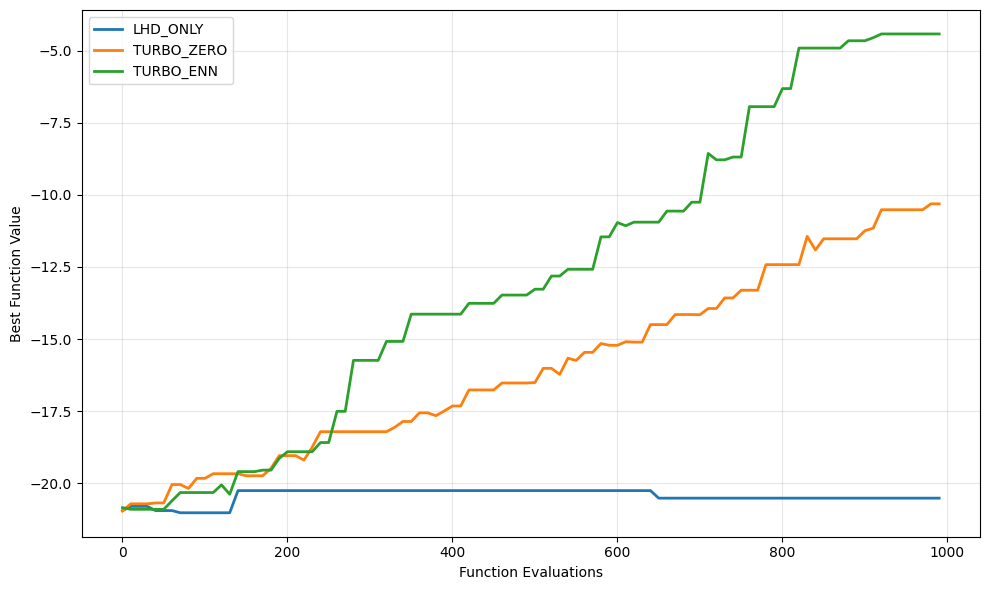

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(evals_lhd, best_values_lhd, linewidth=2, label="LHD_ONLY")
plt.plot(evals_zero, best_values_zero, linewidth=2, label="TURBO_ZERO")
plt.plot(evals_enn, best_values_enn, linewidth=2, label="TURBO_ENN")
if RUN_TURBO_ONE:
    plt.plot(evals_one, best_values_one, linewidth=2, label="TURBO_ONE")
plt.xlabel("Function Evaluations")
plt.ylabel("Best Function Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

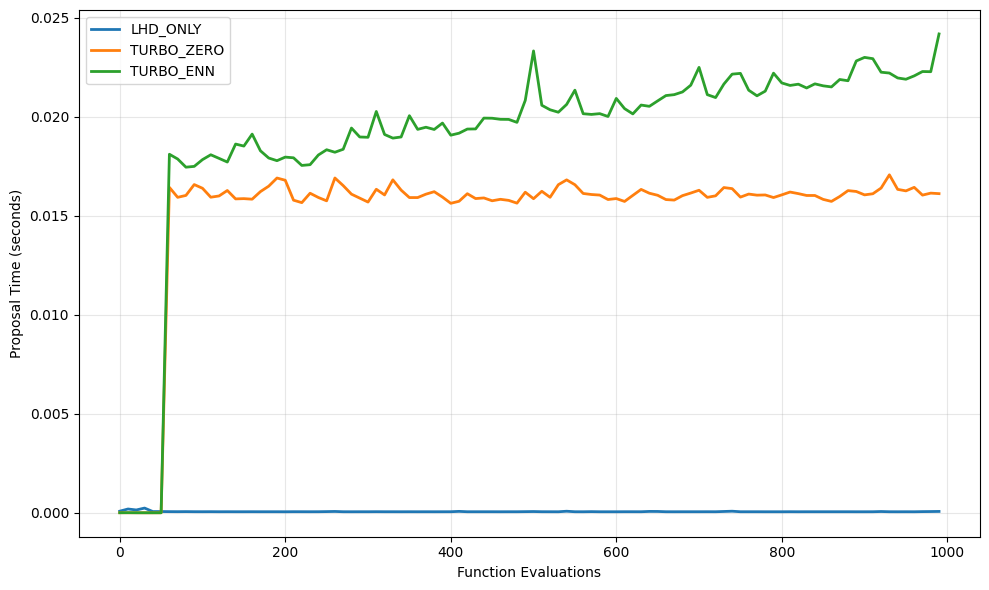

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(evals_lhd, proposal_times_lhd, linewidth=2, label="LHD_ONLY")
plt.plot(evals_zero, proposal_times_zero, linewidth=2, label="TURBO_ZERO")
plt.plot(evals_enn, proposal_times_enn, linewidth=2, label="TURBO_ENN")

if RUN_TURBO_ONE:
    plt.plot(evals_one, proposal_times_one, linewidth=2, label="TURBO_ONE")
plt.xlabel("Function Evaluations")
plt.ylabel("Proposal Time (seconds)")
# c = plt.axis()
# plt.axis([c[0], c[1], 0, 5])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()